# E-commerce Sales Prediction - Exploratory Data Analysis

This notebook contains comprehensive exploratory data analysis for the e-commerce sales prediction project. We'll analyze various aspects of the data to understand patterns and relationships that can help in predicting weekly sales.

## Setup and Data Loading

In [1]:
!pip install pyspark
!pip install findspark
!pip install seaborn

In [2]:
# Import required libraries
import findspark
findspark.init

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, when, count, mean, stddev
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
# Initialize Spark session
spark = SparkSession.builder \
    .appName("SalesPrediction_EDA") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Load the dataset
df = spark.read.csv('/kaggle/input/basalam-comments-and-products/BaSalam.products.csv', header=True, inferSchema=True)

# Display basic information
print("Dataset Overview:")
print(f"Number of records: {df.count():,}")
print(f"Number of features: {len(df.columns)}")
print("\nSchema:")
df.printSchema()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/28 19:53:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Dataset Overview:


Number of records: 2,411,358
Number of features: 43

Schema:
root
 |-- _id: integer (nullable = true)
 |-- _score: double (nullable = true)
 |-- sales_count_week: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- status_id: integer (nullable = true)
 |-- status_title: string (nullable = true)
 |-- stock: integer (nullable = true)
 |-- photo_MEDIUM: string (nullable = true)
 |-- photo_SMALL: string (nullable = true)
 |-- rating_average: double (nullable = true)
 |-- rating_count: integer (nullable = true)
 |-- rating_signals: integer (nullable = true)
 |-- primaryPrice: integer (nullable = true)
 |-- preparationDays: integer (nullable = true)
 |-- weight: integer (nullable = true)
 |-- categoryId: integer (nullable = true)
 |-- has_delivery: boolean (nullable = true)
 |-- has_variation: boolean (nullable = true)
 |-- new_categoryId: integer (nullable = true)
 |-- navigation_id: integer (nullable = true)
 |-- vendor_name: string (nul

## Missing Data Analysis

In [3]:
import pandas as pd

total_count = df.count()
missing_counts = []

for column in df.columns:
    missing_count = df.filter(col(column).isNull()).count()
    missing_percentage = (missing_count / total_count) * 100
    missing_counts.append({
        'column': column,
        'missing_percentage': missing_percentage
    })

missing_df = pd.DataFrame(missing_counts)
missing_df = missing_df.sort_values('missing_percentage', ascending=True)

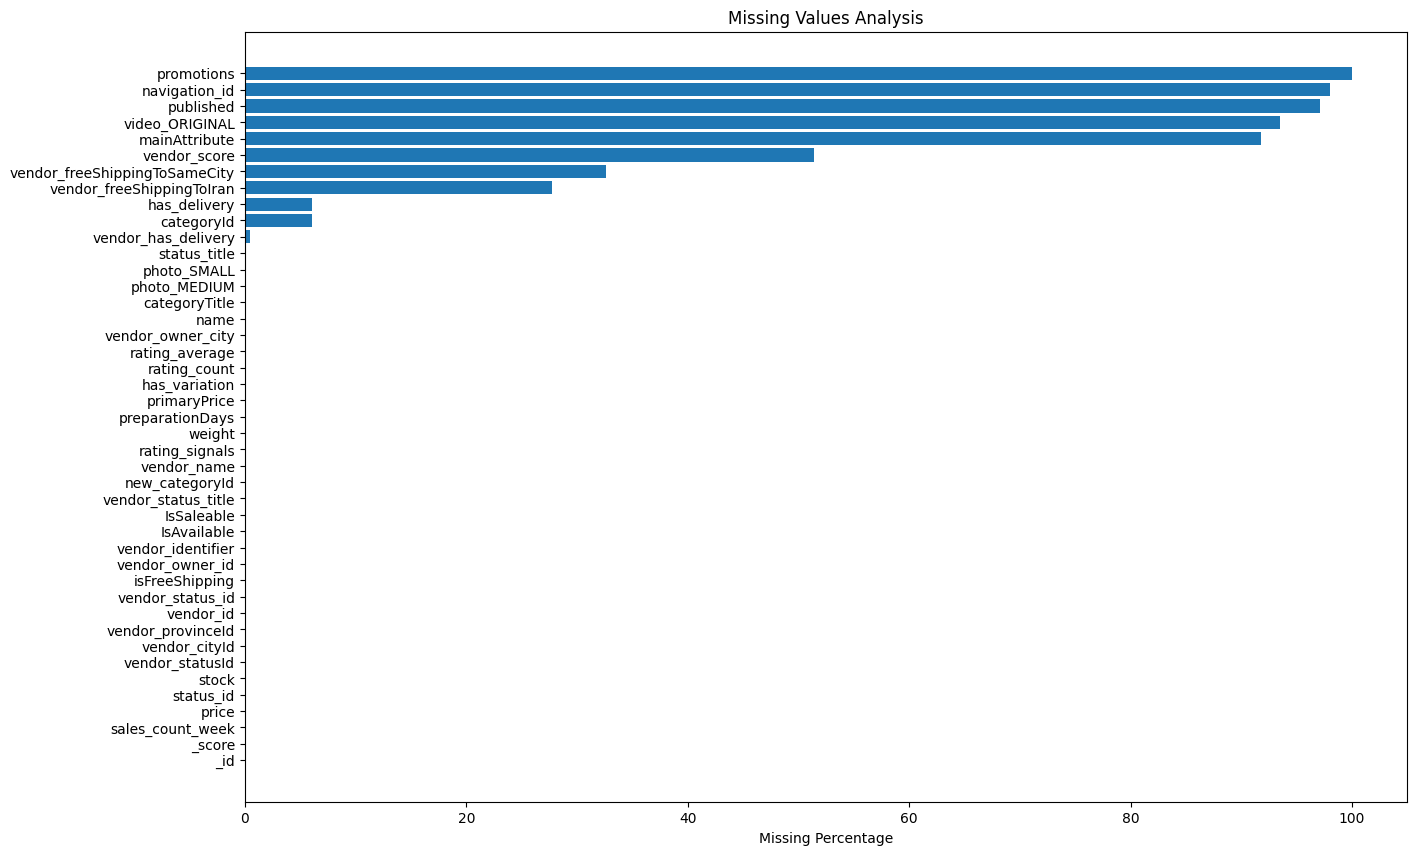

25/04/28 20:00:04 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.



Detailed Missing Value Analysis:
                           Column  Missing Count  Missing Percentage
42                     promotions        2411289           99.997139
20                  navigation_id        2363132           98.000048
40                      published        2341306           97.094915
41                 video_ORIGINAL        2254969           93.514484
38                  mainAttribute        2213550           91.796822
29                   vendor_score        1239540           51.404229
25  vendor_freeShippingToSameCity         786896           32.632898
24      vendor_freeShippingToIran         669330           27.757388
17                   has_delivery         146166            6.061564
16                     categoryId         146163            6.061439
28            vendor_has_delivery          10409            0.431665
6                    status_title           2585            0.107201
8                    photo_MEDIUM            540            0.022394


In [4]:
plt.figure(figsize=(15, 10))
plt.barh(missing_df['column'], missing_df['missing_percentage'])
plt.xlabel('Missing Percentage')
plt.title('Missing Values Analysis')
plt.show()

# Get detailed missing value statistics
missing_stats = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()
missing_stats = missing_stats.T.reset_index()
missing_stats.columns = ['Column', 'Missing Count']
missing_stats['Missing Percentage'] = (missing_stats['Missing Count'] / df.count()) * 100
missing_stats = missing_stats.sort_values('Missing Percentage', ascending=False)

print("\nDetailed Missing Value Analysis:")
print(missing_stats[missing_stats['Missing Percentage'] > 0])

## 2. Descriptive Statistics

In [5]:
from pyspark.sql import functions as F
from pyspark.sql.types import NumericType, StringType, BooleanType, IntegerType

# Assuming `df` is your DataFrame
df_schema = df.dtypes

# Lists to hold the column names
numerical_columns = []
categorical_columns = []
binary_columns = []

# Loop through the schema and classify the columns
for column, dtype in df_schema:
    if isinstance(df.schema[column].dataType, NumericType):
        numerical_columns.append(column)
    elif isinstance(df.schema[column].dataType, StringType):
        categorical_columns.append(column)
    elif isinstance(df.schema[column].dataType, BooleanType):
        binary_columns.append(column)

# Show the results
print("Numerical Columns:", numerical_columns)
print("Categorical Columns:", categorical_columns)
print("Binary Columns:", binary_columns)

Numerical Columns: ['_id', '_score', 'sales_count_week', 'price', 'status_id', 'stock', 'rating_average', 'rating_count', 'rating_signals', 'primaryPrice', 'preparationDays', 'weight', 'categoryId', 'new_categoryId', 'navigation_id', 'vendor_statusId', 'vendor_freeShippingToIran', 'vendor_freeShippingToSameCity', 'vendor_cityId', 'vendor_provinceId', 'vendor_score', 'vendor_id', 'vendor_status_id', 'vendor_owner_id']
Categorical Columns: ['name', 'status_title', 'photo_MEDIUM', 'photo_SMALL', 'vendor_name', 'vendor_identifier', 'vendor_status_title', 'vendor_owner_city', 'mainAttribute', 'categoryTitle', 'video_ORIGINAL', 'promotions']
Binary Columns: ['has_delivery', 'has_variation', 'vendor_has_delivery', 'isFreeShipping', 'IsAvailable', 'IsSaleable', 'published']


In [6]:
from pyspark.sql.functions import col

# Changing the currency to EGP
exchange_rate = 0.00038  # 1 Iranian Rial = 0.00038 Egyptian Pound

# Update the 'price', 'primaryPrice', 'vendor_freeShippingToIran', and 'vendor_freeShippingToSameCity' columns
df = df.withColumn('price', col('price') * exchange_rate) \
       .withColumn('primaryPrice', col('primaryPrice') * exchange_rate) \
       .withColumn('vendor_freeShippingToIran', col('vendor_freeShippingToIran') * exchange_rate) \
       .withColumn('vendor_freeShippingToSameCity', col('vendor_freeShippingToSameCity') * exchange_rate)


In [7]:
# Calculate descriptive statistics for numerical features
numeric_stats = df.select(numerical_columns).describe().toPandas()
print("Numerical Features Statistics:")
display(numeric_stats)

# Display distribution plots for numerical features
# numerical_data = df.select(numerical_columns).toPandas()

# fig, axes = plt.subplots(3, 3, figsize=(15, 15))
# axes = axes.ravel()

# for idx, col in enumerate(numerical_columns):
#     if idx < len(axes):
#         sns.histplot(data=numerical_data, x=col, ax=axes[idx])
#         axes[idx].set_title(f'Distribution of {col}')

# plt.tight_layout()
# plt.show()

Numerical Features Statistics:


,summary,_id,_score,sales_count_week,price,status_id,stock,rating_average,rating_count,rating_signals,...,navigation_id,vendor_statusId,vendor_freeShippingToIran,vendor_freeShippingToSameCity,vendor_cityId,vendor_provinceId,vendor_score,vendor_id,vendor_status_id,vendor_owner_id
0,count,2411358,2411358,2411358,2411356,2411356,2411356,2411355,2411355,2411355,...,48226,2411355,1742028,1624462,2411355,2411355,1171818,2411355,2411355,2411355
1,mean,8597589.141956525,69.34688429883539,0.043767868562030195,3520.0449898123675,2976.8719417622283,32907.0406592805,1.4855676994884555,1.8926437625318544,1.8926437625318544,...,319.3239124123917,2987.000376137068,7192.885315817486,4562.865171418412,2221.1026609520372,13.971001366451642,0.4525916140561077,505573.3472533078,2987.000376137068,6273908.150367324
2,stddev,3402083.73473064,94.1673091389762,0.3214209540235807,13065.909838908383,26.627065291595756,4933175.676261697,2.1954467852079502,15.00858522542236,15.00858522542236,...,879.9023492307176,0.019390609711578684,24096.956886329655,18431.84255541179,321.5811094740018,7.813284836195351,0.49774758298567345,263082.1987844294,0.019390609711578684,4589965.069693647
3,min,20276,0.0,0,3.8000000000000003,2976,0,0.0,0,0,...,1,2987,0.0,0.0,1722,3,0,7,2987,11
4,max,13445061,491.3793,56,379999.9962,3790,1000000000,5.0,4488,4488,...,9982,2988,379999.9962,379999.9962,2967,33,1,967729,2988,15825531


# Key Insights
#### 1. Price vs Score

/tmp/ipykernel_31/3311316705.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_stats = pdf.groupby('price_bin')['_score'].agg(['mean', 'count']).reset_index()


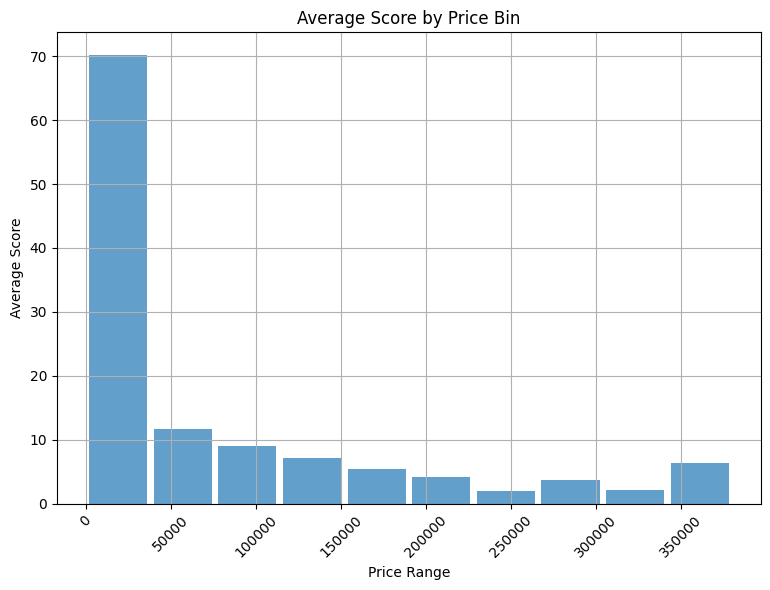

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import functions as F

# Define the number of bins you want
num_bins = 10

# Calculate bins for each price column
price_bins = df.select(F.min("price"), F.max("price")).collect()
min_price, max_price = price_bins[0][0], price_bins[0][1]
price_bin_width = (max_price - min_price) / num_bins

# Create binned columns
df = df.withColumn("price_bin", F.floor((F.col("price") - min_price) / price_bin_width))
# Aggregate average score by price bin
price_score = df.groupBy("price_bin").agg(
    F.avg("_score").alias("avg_score"),
    F.count("*").alias("count")
).orderBy("price_bin")
# Convert aggregated data to Pandas DataFrames
price_pd = price_score.toPandas()
# Calculate bin centers
price_pd['bin_center'] = min_price + (price_pd['price_bin'] + 0.5) * price_bin_width


# Assuming df is your PySpark DataFrame
# First convert the necessary columns to Pandas
pdf = df.select("price", "_score").toPandas()

# Set up the figure
plt.figure(figsize=(15, 6))

# 1. Price vs Score histogram
plt.subplot(1, 2, 1)

# Create bins for price
price_bins = np.linspace(pdf['price'].min(), pdf['price'].max(), num_bins + 1)
pdf['price_bin'] = pd.cut(pdf['price'], bins=price_bins)

# Calculate average score per bin
price_stats = pdf.groupby('price_bin')['_score'].agg(['mean', 'count']).reset_index()

# Plot
plt.bar(price_stats['price_bin'].apply(lambda x: x.mid), 
        price_stats['mean'], 
        width=(price_bins[1]-price_bins[0])*0.9,  # 90% of bin width for spacing
        alpha=0.7)
plt.title('Average Score by Price Bin')
plt.xlabel('Price Range')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.grid(True)

# 2. PrimaryPrice vs Score histogram
plt.subplot(1, 2, 1)

plt.tight_layout()
plt.show()

#### 2. Discount Percentage vs score

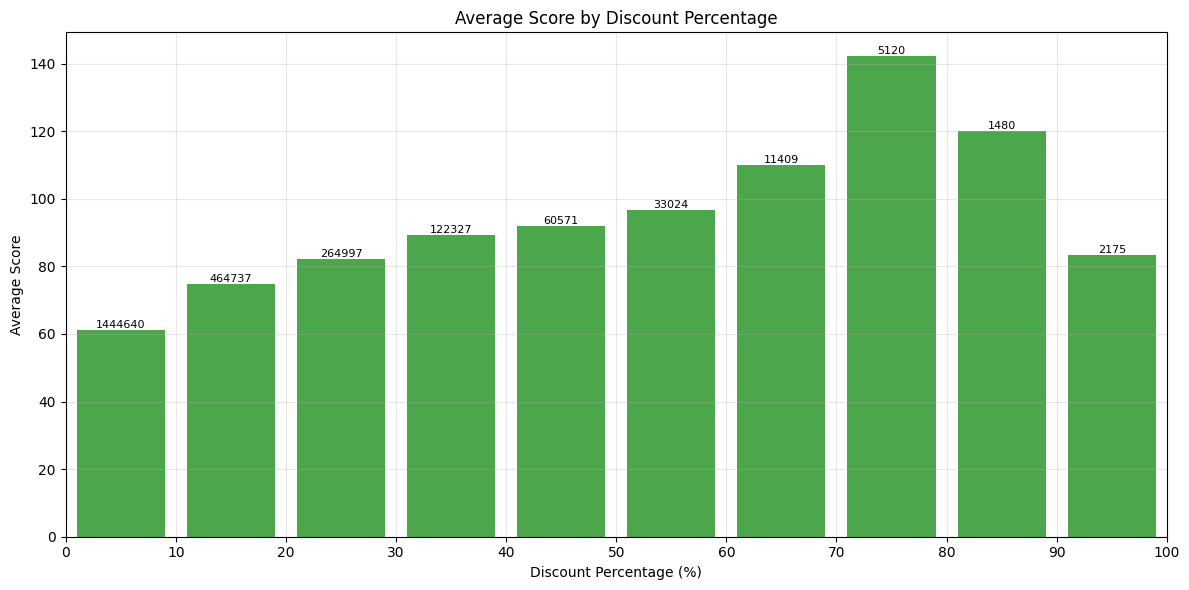

In [9]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1. Calculate Discount Percentage
# If primaryPrice is 0, set discount to 0, otherwise calculate (primaryPrice - price)/primaryPrice
df = df.withColumn(
    "discount_pct",
    F.when(F.col("primaryPrice") == 0, 0)
     .otherwise((F.col("primaryPrice") - F.col("price")) / F.col("primaryPrice") * 100
))

## 2. Filter out invalid discounts (optional)
# Remove cases where discount is negative (price > primaryPrice) or >100%
df = df.filter((F.col("discount_pct") >= 0) & (F.col("discount_pct") <= 100))

## 3. Bin the discount percentages
num_bins = 10  # You can adjust this
df = df.withColumn("discount_bin", F.floor(F.col("discount_pct") / (100/num_bins)))

## 4. Aggregate by bins
discount_stats = df.groupBy("discount_bin").agg(
    F.avg("_score").alias("avg_score"),
    F.count("*").alias("count")
).orderBy("discount_bin")

## 5. Convert to Pandas for plotting
discount_pd = discount_stats.toPandas()

# Calculate bin centers (middle of each range)
discount_pd['bin_center'] = (discount_pd['discount_bin'] + 0.5) * (100/num_bins)

## 6. Create the plot
plt.figure(figsize=(12, 6))

# Main bar plot
bars = plt.bar(discount_pd['bin_center'], 
               discount_pd['avg_score'], 
               width=(100/num_bins)*0.8,
               alpha=0.7,
               color='green')

# Add count labels if desired
for bar, count in zip(bars, discount_pd['count']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(count)}',
             ha='center', va='bottom', fontsize=8)

plt.title('Average Score by Discount Percentage')
plt.xlabel('Discount Percentage (%)')
plt.ylabel('Average Score')
plt.grid(True, alpha=0.3)
plt.xticks(np.arange(0, 101, 10))
plt.xlim(0, 100)

plt.tight_layout()
plt.show()

#### 3. Weight vs Price

In [10]:
from pyspark.sql import functions as F

# Calculate IQR for both weight and price
quantiles = df.approxQuantile(["weight", "price"], [0.25, 0.75], 0.05)
weight_q1, weight_q3 = quantiles[0][0], quantiles[0][1]
price_q1, price_q3 = quantiles[1][0], quantiles[1][1]

# Define bounds (1.5*IQR rule)
weight_iqr = weight_q3 - weight_q1
price_iqr = price_q3 - price_q1

df_clean = df.filter(
    (F.col("weight") >= weight_q1 - 1.5*weight_iqr) &
    (F.col("weight") <= weight_q3 + 1.5*weight_iqr) &
    (F.col("price") >= price_q1 - 1.5*price_iqr) &
    (F.col("price") <= price_q3 + 1.5*price_iqr)
)

print(f"Removed {df.count() - df_clean.count()} outliers")

Removed 460623 outliers


In [11]:
# Re-bin the cleaned data
weight_bins = df_clean.select(
    F.min("weight").alias("min_w"),
    F.max("weight").alias("max_w")
).collect()
min_w, max_w = weight_bins[0][0], weight_bins[0][1]
bin_width = (max_w - min_w) / 20  # Adjust bin count as needed

df_binned = df_clean.withColumn(
    "weight_bin", 
    F.floor((F.col("weight") - min_w) / bin_width)
).groupBy("weight_bin").agg(
    F.avg("price").alias("avg_price"),
    F.count("*").alias("count")
).orderBy("weight_bin")

hist_data = df_binned.toPandas()
hist_data["bin_center"] = min_w + (hist_data["weight_bin"] + 0.5) * bin_width

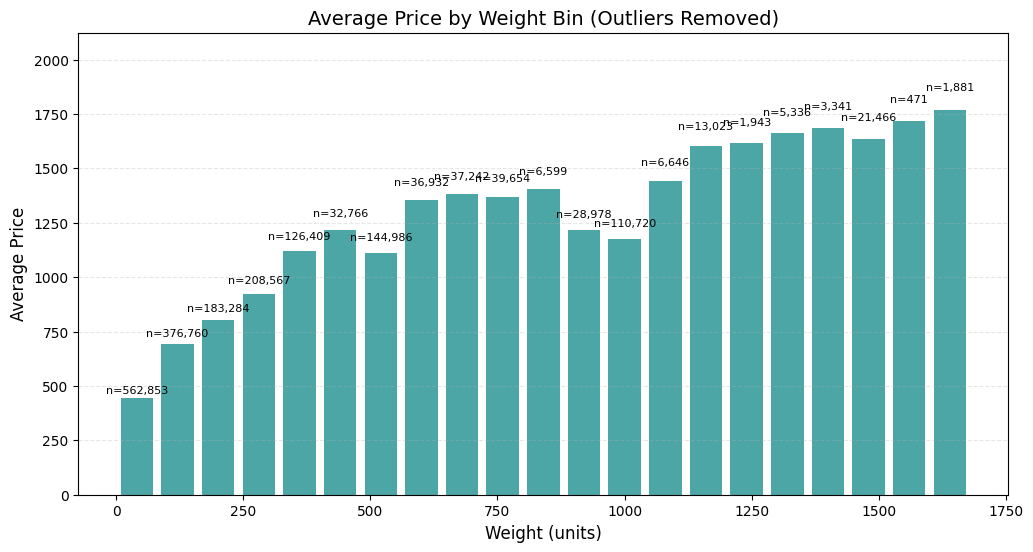

In [12]:
plt.figure(figsize=(12, 6))
bars = plt.bar(
    hist_data["bin_center"], 
    hist_data["avg_price"], 
    width=bin_width*0.8,
    color="teal",
    alpha=0.7
)

# Add count labels (only for bins with reasonable counts)
for idx, row in hist_data.iterrows():
    if row["count"] > 10:  # Only label meaningful bins
        plt.text(
            row["bin_center"], 
            row["avg_price"] * 1.05,  # Position above bar
            f"n={int(row['count']):,}",
            ha="center",
            fontsize=8
        )

plt.title("Average Price by Weight Bin (Outliers Removed)", fontsize=14)
plt.xlabel("Weight (units)", fontsize=12)
plt.ylabel("Average Price", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.3)

# Set y-axis limit based on cleaned data
plt.ylim(0, hist_data["avg_price"].max() * 1.2)

plt.show()

#### 4. isFreeShipping vs Score

In [13]:
from pyspark.sql import functions as F

# Calculate average scores by free shipping status
score_comparison = df.groupBy("isFreeShipping").agg(
    F.avg("_score").alias("average_score"),
    F.count("*").alias("product_count"),
    F.stddev("_score").alias("score_stddev"),
    F.percentile_approx("_score", 0.5).alias("median_score")
).orderBy("isFreeShipping")

# Show results
score_comparison.show()

+--------------+-----------------+-------------+-----------------+------------+
|isFreeShipping|    average_score|product_count|     score_stddev|median_score|
+--------------+-----------------+-------------+-----------------+------------+
|         false|70.06915064404055|      1962935|94.62893461042427|         0.0|
|          true|66.14196883203742|       447545|92.06192811862704|         0.0|
+--------------+-----------------+-------------+-----------------+------------+



#### 5. has_variation vs Score

In [14]:
from pyspark.sql import functions as F

# Calculate average scores by free shipping status
score_comparison = df.groupBy("has_variation").agg(
    F.avg("_score").alias("average_score"),
    F.count("*").alias("product_count"),
    F.stddev("_score").alias("score_stddev"),
    F.percentile_approx("_score", 0.5).alias("median_score")
).orderBy("has_variation")

# Show results
score_comparison.show()

+-------------+-----------------+-------------+------------------+------------+
|has_variation|    average_score|product_count|      score_stddev|median_score|
+-------------+-----------------+-------------+------------------+------------+
|        false|68.16980545988014|      2282435| 93.39780297423225|         0.0|
|         true| 90.1991154324632|       128045|104.83460398483683|   83.333336|
+-------------+-----------------+-------------+------------------+------------+



#### 6. isFreeShipping vs Weight

In [15]:
from pyspark.sql import functions as F

# Weight vs isFreshipping
score_comparison = df.groupBy("isFreeShipping").agg(
    F.avg("weight").alias("average_weight"),
    F.count("*").alias("product_count"),
    F.stddev("weight").alias("weight_stddev"),
    F.percentile_approx("_score", 0.5).alias("median_weight")
).orderBy("isFreeShipping")

# Show results
score_comparison.show()

+--------------+-----------------+-------------+----------------+-------------+
|isFreeShipping|   average_weight|product_count|   weight_stddev|median_weight|
+--------------+-----------------+-------------+----------------+-------------+
|         false|2639.846525738244|      1962935|26316.4469752969|          0.0|
|          true|3182.767359706845|       447545|22047.0597815616|          0.0|
+--------------+-----------------+-------------+----------------+-------------+



In [16]:
from pyspark.sql import functions as F

# Weight vs isFreshipping
score_comparison = df.groupBy("isFreeShipping").agg(
    F.avg("price").alias("average_price"),
    F.count("*").alias("product_count"),
).orderBy("isFreeShipping")

# Show results
score_comparison.show()

+--------------+------------------+-------------+
|isFreeShipping|     average_price|product_count|
+--------------+------------------+-------------+
|         false|2719.0726984141443|      1962935|
|          true| 7034.415226796704|       447545|
+--------------+------------------+-------------+



#### 7. has_delivery vs score

In [17]:
from pyspark.sql import functions as F

# Calculate average scores by free shipping status
score_comparison = df.groupBy("has_delivery").agg(
    F.avg("_score").alias("average_score"),
    F.count("*").alias("product_count"),
    F.stddev("_score").alias("score_stddev"),
    F.percentile_approx("_score", 0.5).alias("median_score")
).orderBy("has_delivery")

# Show results
score_comparison.show()

+------------+------------------+-------------+-----------------+------------+
|has_delivery|     average_score|product_count|     score_stddev|median_score|
+------------+------------------+-------------+-----------------+------------+
|        NULL|22.231832202530384|       146161|76.43132176759735|         0.0|
|       false|  73.3332796689455|       837960|94.67130511997655|         0.0|
|        true| 71.82126926144588|      1426359|94.23138642423253|         0.0|
+------------+------------------+-------------+-----------------+------------+



#### 8. top vendors that has highest scores

In [18]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Calculate vendor statistics
vendor_stats = df.groupBy("vendor_id", "vendor_name").agg(
    F.avg("_score").alias("avg_score"),
    F.count("*").alias("product_count"),
    F.stddev("_score").alias("score_stddev"),
    F.min("_score").alias("min_score"),
    F.max("_score").alias("max_score")
).filter(F.col("product_count") > 10)  # Only vendors with sufficient products

# Add consistency metric (lower stddev = more consistent)
vendor_stats = vendor_stats.withColumn(
    "consistency",
    1/F.col("score_stddev")  # Higher value = more consistent
)

# Rank vendors by average score
window = Window.orderBy(F.desc("avg_score"))
vendor_stats = vendor_stats.withColumn("rank", F.rank().over(window))

# Show top 20 vendors
top_vendors = vendor_stats.filter(F.col("rank") <= 20).orderBy("rank")
top_vendors.show(truncate=False)

25/04/28 20:03:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/28 20:03:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/28 20:03:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/28 20:03:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/28 20:03:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/28 20:03:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/28 2

+---------+---------------------------------------+------------------+-------------+------------------+---------+---------+--------------------+----+
|vendor_id|vendor_name                            |avg_score         |product_count|score_stddev      |min_score|max_score|consistency         |rank|
+---------+---------------------------------------+------------------+-------------+------------------+---------+---------+--------------------+----+
|955611   |عطر  و ادکلن امیر    021               |397.5563905263158 |19           |21.256930430010996|333.33334|428.57144|0.04704348086815857 |1   |
|792312   |لوتوس_پرفیوم                           |385.5116527659574 |47           |25.454701595903536|333.33334|428.57144|0.039285473303718926|2   |
|317479   |تولید و پخش روانبخش شوقی               |368.6921273076924 |26           |64.44257545674174 |245.28302|454.54544|0.015517691416154967|3   |
|818658   |گالری جیحون                            |348.750003        |20           |35.7945512980899

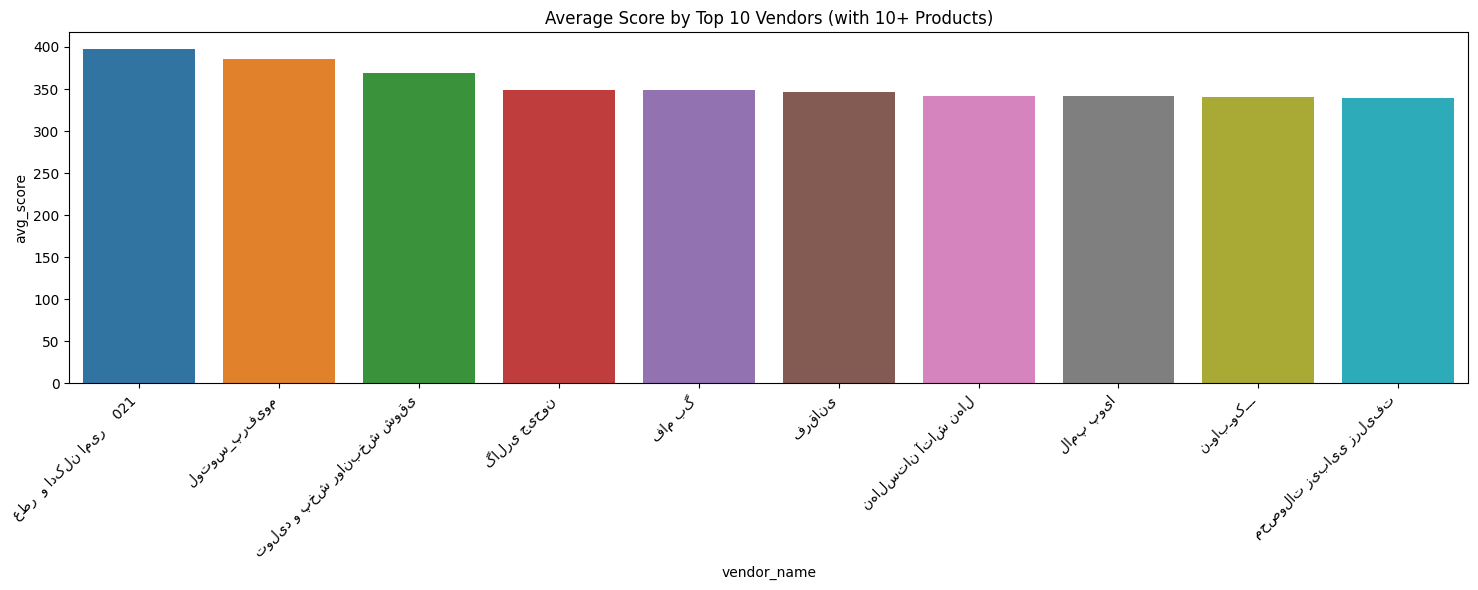

Vendor Statistics:


,vendor_name,avg_score,product_count
70782,عطر و ادکلن امیر 021,397.556391,19
27327,لوتوس_پرفیوم,385.511653,47
2698,تولید و پخش روانبخش شوقی,368.692127,26
47489,گالری جیحون,348.750003,20
70899,فام بگ,348.696471,19
47068,فرقانی,346.036798,33
25575,نهالستان آتاش نهال,341.597043,93
46254,لامپ پویا,341.187390,56
27748,نـوابـوکـــ,340.104173,16
72980,محصولات زیبایی زرلیفت,339.285720,14


In [19]:
vendor_analysis = df.groupBy('vendor_name').agg(
    F.avg('_score').alias('avg_score'),
    F.count('*').alias('product_count'),
).toPandas()

vendor_analysis = vendor_analysis[vendor_analysis['product_count'] >= 10]

plt.figure(figsize=(15, 6))
top_vendors = vendor_analysis.nlargest(10, 'avg_score')
sns.barplot(data=top_vendors, x='vendor_name', y='avg_score')
plt.xticks(rotation=45, ha='right')
plt.title('Average Score by Top 10 Vendors (with 10+ Products)')
plt.tight_layout()
plt.show()

print("Vendor Statistics:")
display(vendor_analysis.sort_values('avg_score', ascending=False).head(10))


#### 8. Top Categories that has highest scores

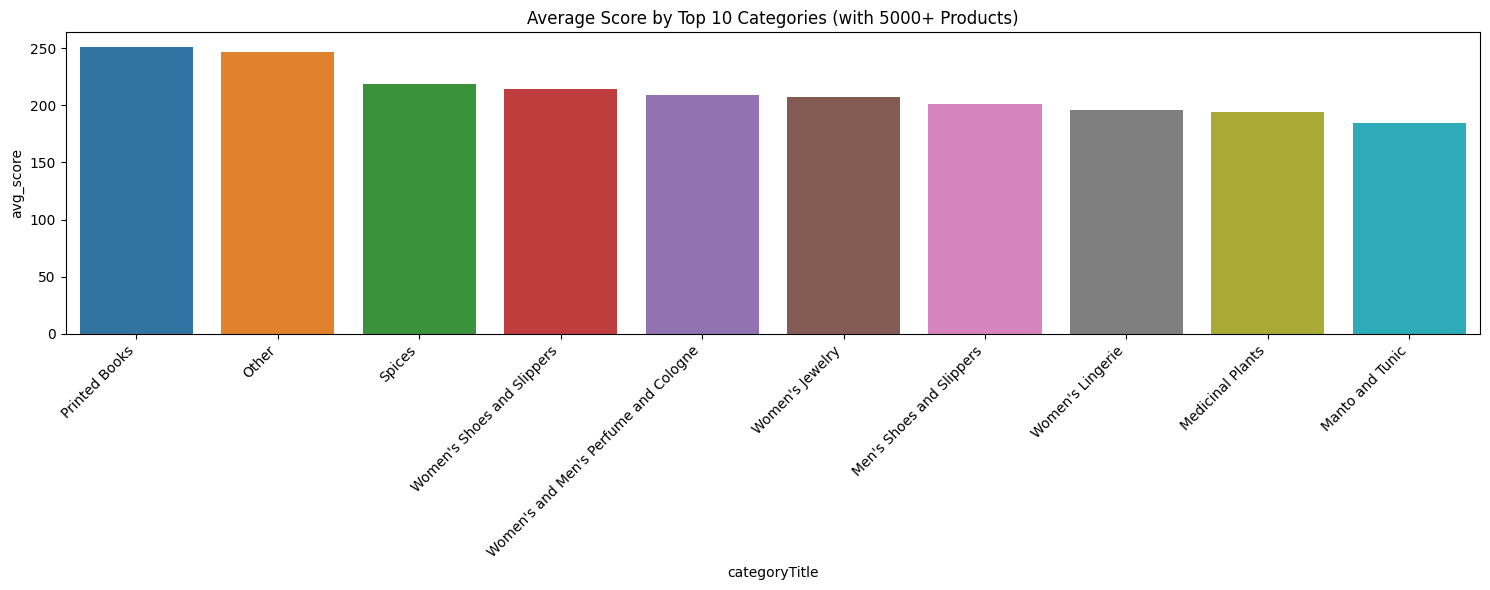


Category Statistics:


,categoryTitle,avg_score,product_count,avg_price,avg_rating
76,Printed Books,251.211514,9309,561.544268,4.275475
706,Other,246.701232,10126,746.654993,4.267845
346,Spices,218.270097,9267,472.576535,4.264778
524,Women's Shoes and Slippers,214.143012,8863,1480.636422,4.099774
460,Women's and Men's Perfume and Cologne,209.254075,9053,975.348667,3.820082
312,Women's Jewelry,207.374318,8966,626.773713,4.211097
95,Men's Shoes and Slippers,200.960650,8925,2245.632630,3.989894
311,Women's Lingerie,195.632041,8813,521.570904,4.109202
535,Medicinal Plants,194.139576,8948,589.865899,3.561544
126,Manto and Tunic,184.599138,8687,1703.749170,3.777771


In [20]:
# Translation dictionary for category titles
# Updated Translation dictionary for category titles
category_translation = {
    'گام شمار': 'Pedometer',
    'کتاب چاپی': 'Printed Books',
    'طلق موتور': 'Motor Oil',
    'کفش و دمپایی زنانه': 'Women\'s Shoes and Slippers',
    'غذای ماهی و میگو': 'Fish and Shrimp Food',
    'کفش، دمپایی مردانه': 'Men\'s Shoes and Slippers',
    'بذر و تخم گیاهان': 'Seeds and Plant Seeds',
    'ذخیره سازی مبتنی بر نوار': 'Tape-based Storage',
    'عطر و ادکلن زنانه و مردانه': 'Women\'s and Men\'s Perfume and Cologne',
    'سایر': 'Other',
    'ادویه': 'Spices',
    'زیورآلات زنانه': 'Women\'s Jewelry',
    'لباس زیر زنانه': 'Women\'s Lingerie',
    'گیاهان دارویی': 'Medicinal Plants',
    'مانتو و تونیک': 'Manto and Tunic'
}


# Analyze sales by category with product count threshold
category_analysis = df.groupBy('categoryTitle').agg(
    F.avg('_score').alias('avg_score'),
    F.count('*').alias('product_count'),
    F.avg('price').alias('avg_price'),
    F.avg('rating_average').alias('avg_rating')
).toPandas()

# Apply threshold to filter out categories with less than 5000 products
category_analysis = category_analysis[category_analysis['product_count'] >= 5000]

# Translate category titles
category_analysis['categoryTitle'] = category_analysis['categoryTitle'].map(category_translation).fillna(category_analysis['categoryTitle'])

# Plot top categories by average score
plt.figure(figsize=(15, 6))
top_categories = category_analysis.nlargest(10, 'avg_score')
sns.barplot(data=top_categories, x='categoryTitle', y='avg_score')
plt.xticks(rotation=45, ha='right')
plt.title('Average Score by Top 10 Categories (with 5000+ Products)')
plt.tight_layout()
plt.show()

# Display category statistics
print("\nCategory Statistics:")
display(category_analysis.sort_values('avg_score', ascending=False).head(10))


#### 9. vendor city vs score

In [21]:
from pyspark.sql import functions as F

# Calculate city statistics (only for cities with sufficient vendors)
city_stats = df.groupBy("vendor_cityId", "vendor_owner_city").agg(
    F.avg("_score").alias("avg_score"),
    F.countDistinct("vendor_id").alias("vendor_count"),
    F.count("*").alias("product_count"),
    F.stddev("_score").alias("score_stddev")
).filter(F.col("product_count") >= 10)  # Only cities with 5+ vendors

# Rank cities by average score
window = Window.partitionBy().orderBy(F.desc("avg_score"))  # Explicit empty partition
city_stats = city_stats.withColumn("rank", F.rank().over(window))

# Show top/bottom 10 cities
display(city_stats.orderBy("rank").limit(10))
display(city_stats.orderBy(F.desc("rank")).limit(10))

DataFrame[vendor_cityId: int, vendor_owner_city: string, avg_score: double, vendor_count: bigint, product_count: bigint, score_stddev: double, rank: int]

DataFrame[vendor_cityId: int, vendor_owner_city: string, avg_score: double, vendor_count: bigint, product_count: bigint, score_stddev: double, rank: int]

25/04/28 20:03:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/28 20:03:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/28 20:03:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/28 20:04:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/28 20:04:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/28 20:04:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/28 2

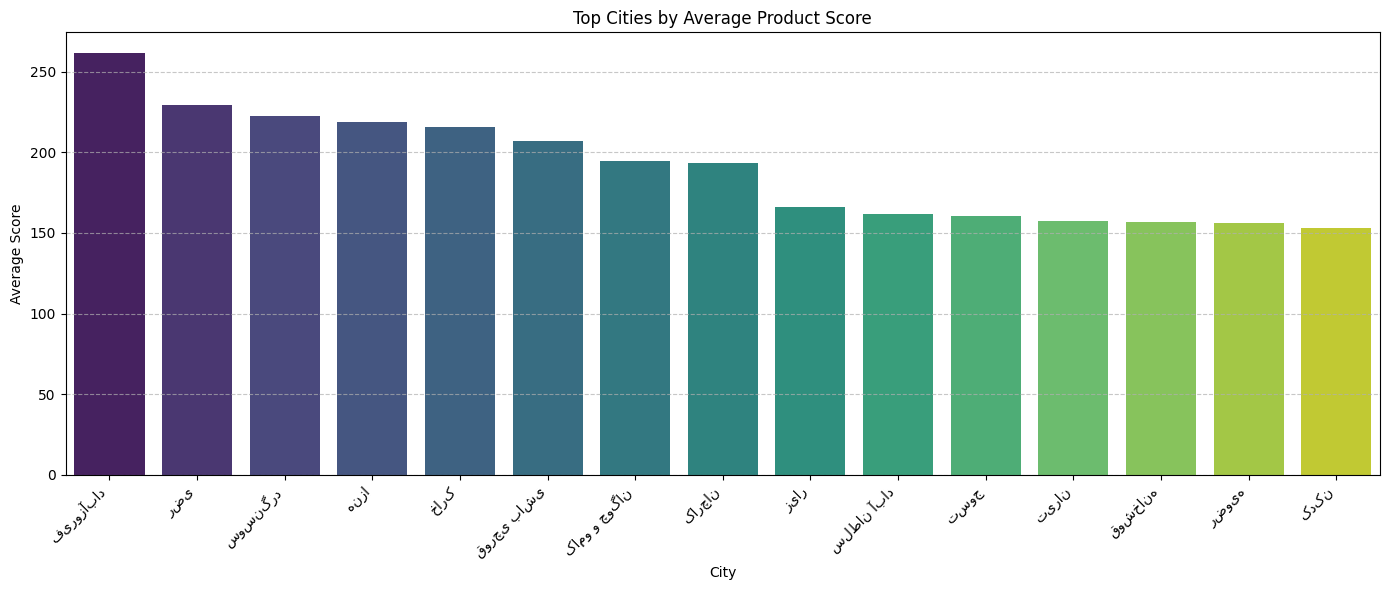

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert top cities to Pandas
top_cities_pd = city_stats.filter(F.col("rank") <= 15).toPandas()

# Plot: Bar Chart of Average Scores for Top Cities
plt.figure(figsize=(14, 6))
sns.barplot(
    x="vendor_owner_city",
    y="avg_score",
    data=top_cities_pd,
    palette="viridis",
    order=top_cities_pd.sort_values("avg_score", ascending=False)["vendor_owner_city"]
)
plt.xticks(rotation=45, ha='right')
plt.title("Top Cities by Average Product Score")
plt.xlabel("City")
plt.ylabel("Average Score")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

#### 10. Determine which vendors receive the highest customer satisfaction ratings. 

Adjusted Rating= ((avg_rating×rating_count)+(global_mean×min_samples)) / (rating_count+min_samples)

In [23]:
from pyspark.sql import functions as F

# Calculate global mean and minimum sample threshold
global_mean = df.select(F.avg("rating_average")).first()[0]
min_samples = 100  # Adjust based on your data

vendor_stats = df.groupBy("vendor_id", "vendor_name").agg(
    F.avg("rating_average").alias("avg_rating"),
    F.sum("rating_count").alias("total_ratings")
).filter(F.col("total_ratings") > min_samples)

# Apply Bayesian Average
vendor_stats = vendor_stats.withColumn(
    "adjusted_rating",
    (F.col("avg_rating") * F.col("total_ratings") + global_mean * min_samples) / 
    (F.col("total_ratings") + min_samples)
)

# Rank by adjusted rating
window = Window.orderBy(F.desc("adjusted_rating"))
vendor_stats = vendor_stats.withColumn("rank", F.rank().over(window))

25/04/28 20:04:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/28 20:04:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/28 20:04:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/28 20:04:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/28 20:04:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/28 20:04:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/28 2

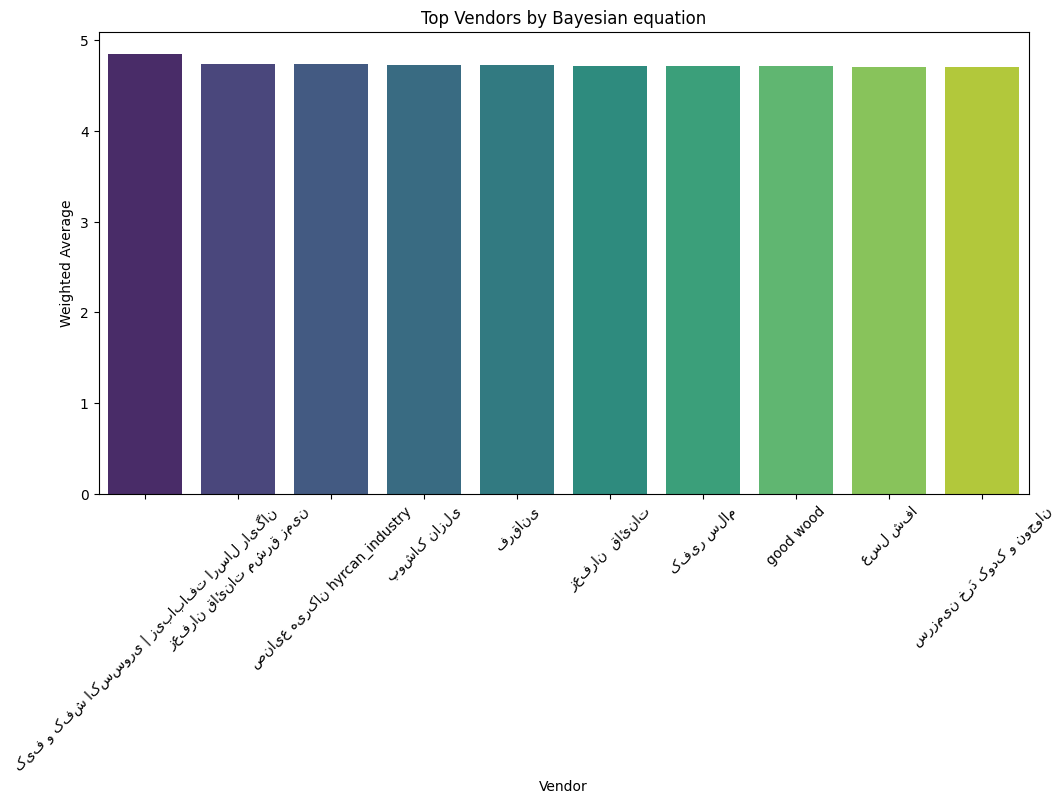

In [24]:
top_vendors_pd = vendor_stats.orderBy("rank").limit(10).toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(
    x="vendor_name",
    y="adjusted_rating",  # or "wilson_score"/"weighted_score"
    data=top_vendors_pd,
    palette="viridis"
)
plt.xticks(rotation=45)
plt.title("Top Vendors by Bayesian equation")
plt.ylabel("Weighted Average")
plt.xlabel("Vendor")
plt.show()

#### 11. score vs average rating

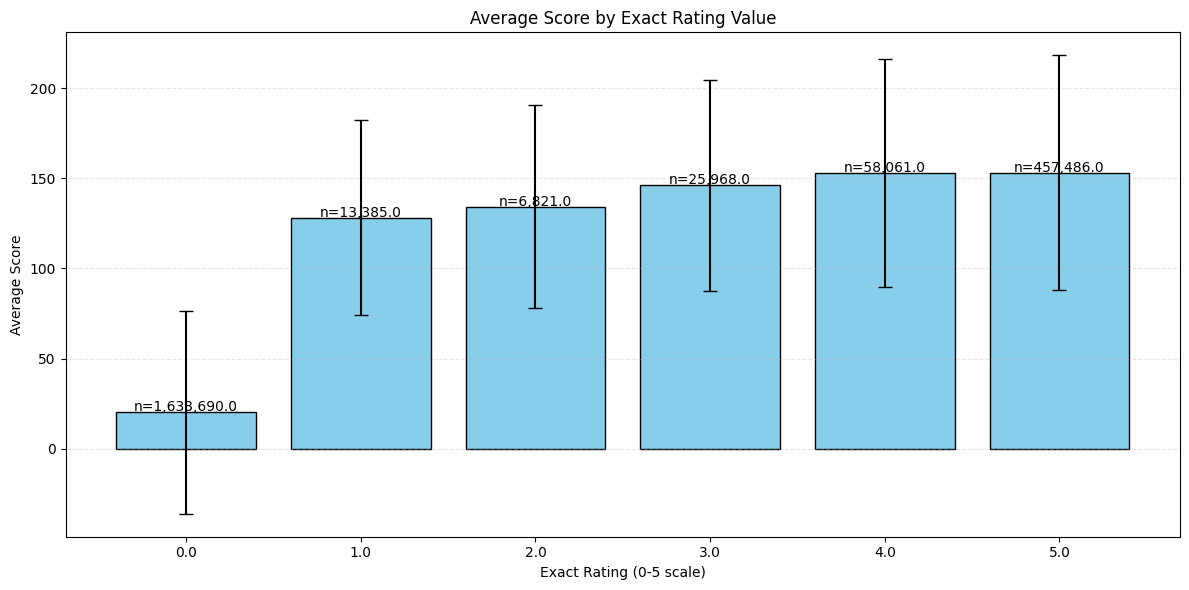

In [25]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import numpy as np

# Group by exact rating values (0-5)
rating_analysis = df.groupBy("rating_average") \
    .agg(
        F.avg("_score").alias("avg_score"),
        F.count("*").alias("product_count"),
        F.stddev("_score").alias("score_stddev")
    ) \
    .filter(F.col("rating_average").isin([0, 1, 2, 3, 4, 5])) \
    .orderBy("rating_average") \
    .toPandas()

# Plot
plt.figure(figsize=(12, 6))
plt.bar(
    rating_analysis["rating_average"].astype(str),  # Convert ratings to strings for labels
    rating_analysis["avg_score"],
    yerr=rating_analysis["score_stddev"],  # Show standard deviation as error bars
    capsize=5,
    color="skyblue",
    edgecolor="black"
)

# Annotate bars with product counts
for i, row in rating_analysis.iterrows():
    plt.text(
        i,
        row["avg_score"] + 0.5,  # Position above bar
        f"n={row['product_count']:,}",
        ha="center",
        fontsize=10
    )

plt.xlabel("Exact Rating (0-5 scale)")
plt.ylabel("Average Score")
plt.title("Average Score by Exact Rating Value")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

#### 12. score vs sales

Working with 76,913 records after cleaning



Cleaned Data Statistics:
Average weekly sales: 1.37 ± 1.19
Average score: 344.38 ± 24.54


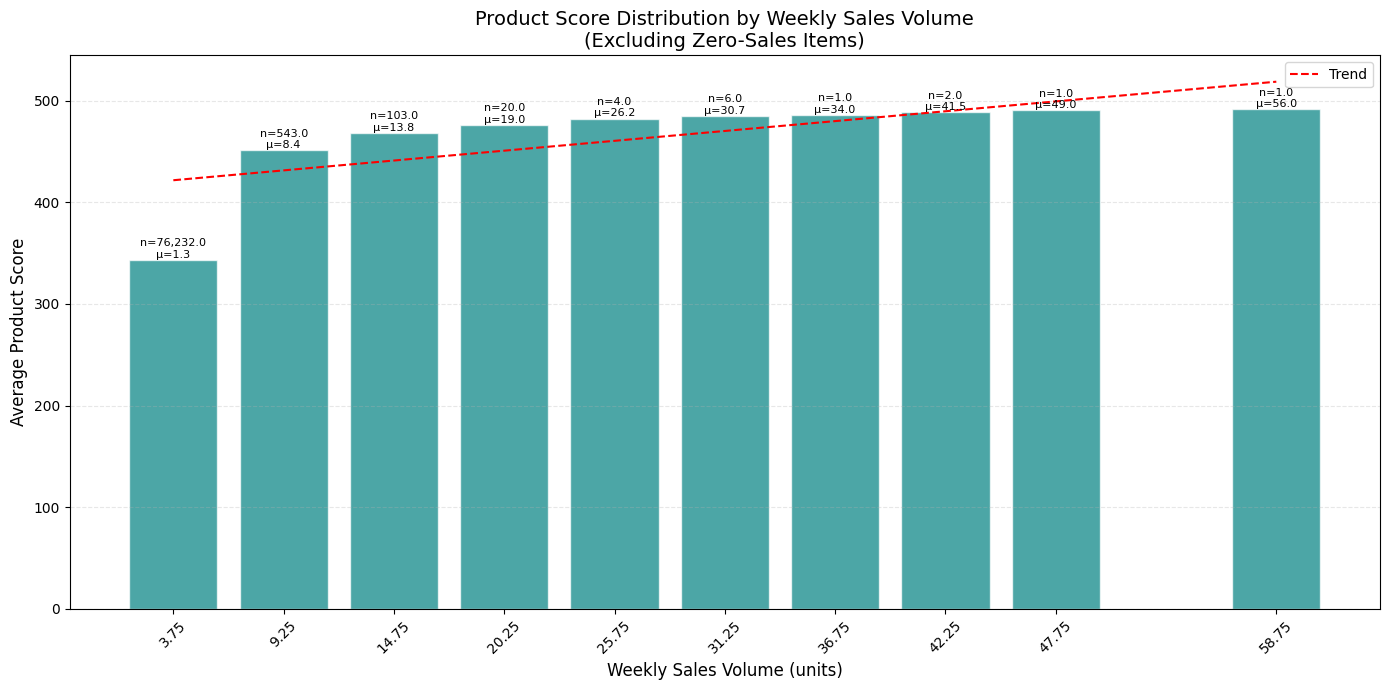


Correlation between sales volume and score: 0.847


In [26]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import numpy as np

# 1. Remove rows with zero sales and create cleaned dataset
df_clean = df.filter(F.col("sales_count_week") > 0)

# Report how many rows were removed
original_count = df.count()
cleaned_count = df_clean.count()
print(f"Working with {cleaned_count:,} records after cleaning")

# 2. Calculate basic statistics for the cleaned data
cleaned_stats = df_clean.select(
    F.mean("sales_count_week").alias("mean_sales"),
    F.stddev("sales_count_week").alias("std_sales"),
    F.mean("_score").alias("mean_score"),
    F.stddev("_score").alias("std_score")
).collect()[0]

print("\nCleaned Data Statistics:")
print(f"Average weekly sales: {cleaned_stats.mean_sales:.2f} ± {cleaned_stats.std_sales:.2f}")
print(f"Average score: {cleaned_stats.mean_score:.2f} ± {cleaned_stats.std_score:.2f}")

# 3. Create bins for analysis (using 10 bins by default)
num_bins = 10
sales_range = df_clean.select(
    F.min("sales_count_week").alias("min"),
    F.max("sales_count_week").alias("max")
).collect()[0]

bin_width = (sales_range.max - sales_range.min) / num_bins

# 4. Bin the data and calculate aggregates
binned_data = df_clean.withColumn(
    "sales_bin",
    F.floor((F.col("sales_count_week") - sales_range.min) / bin_width)
).groupBy("sales_bin").agg(
    F.avg("_score").alias("avg_score"),
    F.count("*").alias("product_count"),
    F.avg("sales_count_week").alias("bin_avg_sales")
).orderBy("sales_bin")

# Convert to Pandas for visualization
binned_pd = binned_data.toPandas()
binned_pd["bin_center"] = sales_range.min + (binned_pd["sales_bin"] + 0.5) * bin_width

# 5. Create enhanced visualization
plt.figure(figsize=(14, 7))

# Main bar plot
bars = plt.bar(
    binned_pd["bin_center"],
    binned_pd["avg_score"],
    width=bin_width * 0.8,
    color="teal",
    alpha=0.7,
    edgecolor="white"
)

# Add data labels for product counts
for idx, row in binned_pd.iterrows():
    plt.text(
        row["bin_center"],
        row["avg_score"] + 0.1,
        f"n={row['product_count']:,}\nμ={row['bin_avg_sales']:.1f}",
        ha="center",
        va="bottom",
        fontsize=8
    )

# Add trend line
z = np.polyfit(binned_pd["bin_center"], binned_pd["avg_score"], 1)
p = np.poly1d(z)
plt.plot(
    binned_pd["bin_center"],
    p(binned_pd["bin_center"]),
    color="red",
    linestyle="--",
    label="Trend"
)

# Formatting
plt.title("Product Score Distribution by Weekly Sales Volume\n(Excluding Zero-Sales Items)", fontsize=14)
plt.xlabel("Weekly Sales Volume (units)", fontsize=12)
plt.ylabel("Average Product Score", fontsize=12)
plt.xticks(binned_pd["bin_center"], rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# 6. Show correlation coefficient
correlation = df_clean.corr("sales_count_week", "_score")
print(f"\nCorrelation between sales volume and score: {correlation:.3f}")

Price vs vendor_freeshippingtoIran threshold

/tmp/ipykernel_31/3968411223.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_stats = pdf.groupby('price_bin')['vendor_freeshippingtoIran'].agg(['mean', 'count']).reset_index()


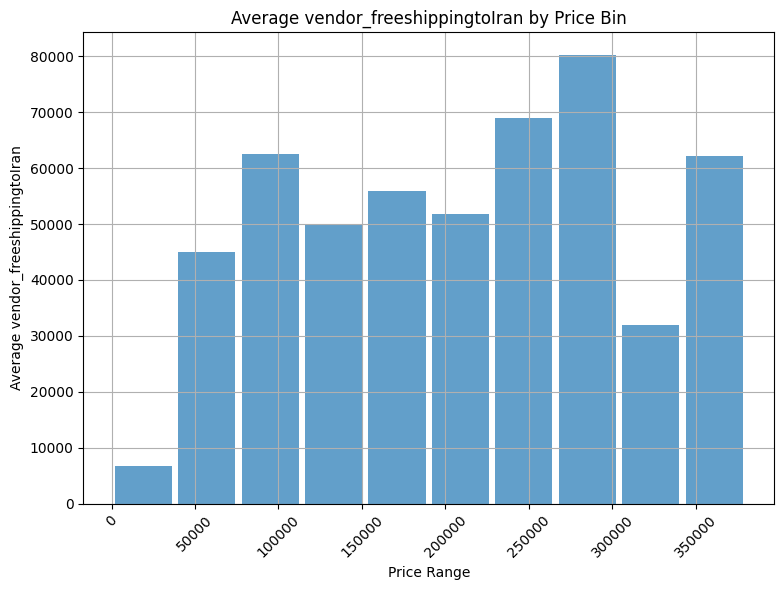

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import functions as F

# Define the number of bins you want
num_bins = 10

# Calculate bins for each price column
price_bins = df.select(F.min("price"), F.max("price")).collect()
min_price, max_price = price_bins[0][0], price_bins[0][1]
price_bin_width = (max_price - min_price) / num_bins

# Create binned columns
df = df.withColumn("price_bin", F.floor((F.col("price") - min_price) / price_bin_width))
# Aggregate average vendor_freeshippingtoIran by price bin
price_vendor_freeshippingtoIran = df.groupBy("price_bin").agg(
    F.avg("vendor_freeshippingtoIran").alias("avg_vendor_freeshippingtoIran"),
    F.count("*").alias("count")
).orderBy("price_bin")
# Convert aggregated data to Pandas DataFrames
price_pd = price_vendor_freeshippingtoIran.toPandas()
# Calculate bin centers
price_pd['bin_center'] = min_price + (price_pd['price_bin'] + 0.5) * price_bin_width


# Assuming df is your PySpark DataFrame
# First convert the necessary columns to Pandas
pdf = df.select("price", "vendor_freeshippingtoIran").toPandas()

# Set up the figure
plt.figure(figsize=(15, 6))

# 1. Price vs vendor_freeshippingtoIran histogram
plt.subplot(1, 2, 1)

# Create bins for price
price_bins = np.linspace(pdf['price'].min(), pdf['price'].max(), num_bins + 1)
pdf['price_bin'] = pd.cut(pdf['price'], bins=price_bins)

# Calculate average vendor_freeshippingtoIran per bin
price_stats = pdf.groupby('price_bin')['vendor_freeshippingtoIran'].agg(['mean', 'count']).reset_index()

# Plot
plt.bar(price_stats['price_bin'].apply(lambda x: x.mid), 
        price_stats['mean'], 
        width=(price_bins[1]-price_bins[0])*0.9,  # 90% of bin width for spacing
        alpha=0.7)
plt.title('Average vendor_freeshippingtoIran by Price Bin')
plt.xlabel('Price Range')
plt.ylabel('Average vendor_freeshippingtoIran')
plt.xticks(rotation=45)
plt.grid(True)

# 2. PrimaryPrice vs vendor_freeshippingtoIran histogram
plt.subplot(1, 2, 1)

plt.tight_layout()
plt.show()

Price vs vendor_freeShippingToSameCity threshold

/tmp/ipykernel_31/3177561396.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_stats = pdf.groupby('price_bin')['vendor_freeShippingToSameCity'].agg(['mean', 'count']).reset_index()


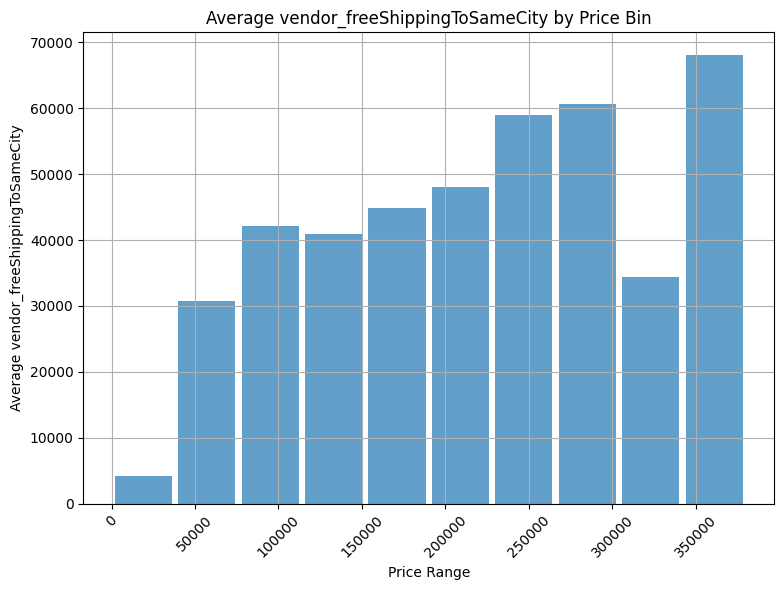

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import functions as F

# Define the number of bins you want
num_bins = 10

# Calculate bins for each price column
price_bins = df.select(F.min("price"), F.max("price")).collect()
min_price, max_price = price_bins[0][0], price_bins[0][1]
price_bin_width = (max_price - min_price) / num_bins

# Create binned columns
df = df.withColumn("price_bin", F.floor((F.col("price") - min_price) / price_bin_width))
# Aggregate average vendor_freeShippingToSameCity by price bin
price_vendor_freeshippingtoIran = df.groupBy("price_bin").agg(
    F.avg("vendor_freeShippingToSameCity").alias("vendor_freeShippingToSameCity"),
    F.count("*").alias("count")
).orderBy("price_bin")
# Convert aggregated data to Pandas DataFrames
price_pd = price_vendor_freeshippingtoIran.toPandas()
# Calculate bin centers
price_pd['bin_center'] = min_price + (price_pd['price_bin'] + 0.5) * price_bin_width


# Assuming df is your PySpark DataFrame
# First convert the necessary columns to Pandas
pdf = df.select("price", "vendor_freeShippingToSameCity").toPandas()

# Set up the figure
plt.figure(figsize=(15, 6))

# 1. Price vs vendor_freeShippingToSameCity histogram
plt.subplot(1, 2, 1)

# Create bins for price
price_bins = np.linspace(pdf['price'].min(), pdf['price'].max(), num_bins + 1)
pdf['price_bin'] = pd.cut(pdf['price'], bins=price_bins)

# Calculate average vendor_freeshippingtoIran per bin
price_stats = pdf.groupby('price_bin')['vendor_freeShippingToSameCity'].agg(['mean', 'count']).reset_index()

# Plot
plt.bar(price_stats['price_bin'].apply(lambda x: x.mid), 
        price_stats['mean'], 
        width=(price_bins[1]-price_bins[0])*0.9,  # 90% of bin width for spacing
        alpha=0.7)
plt.title('Average vendor_freeShippingToSameCity by Price Bin')
plt.xlabel('Price Range')
plt.ylabel('Average vendor_freeShippingToSameCity')
plt.xticks(rotation=45)
plt.grid(True)

# 2. PrimaryPrice vs vendor_freeShippingToSameCity histogram
plt.subplot(1, 2, 1)

plt.tight_layout()
plt.show()

Weight vs vendor_freeshippingtoIran threshold



/tmp/ipykernel_31/2322790980.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vendor_freeShippingToSameCity_stats = pdf.groupby('vendor_freeShippingToSameCity_bin')['vendor_freeshippingtoIran'].agg(['mean', 'count']).reset_index()


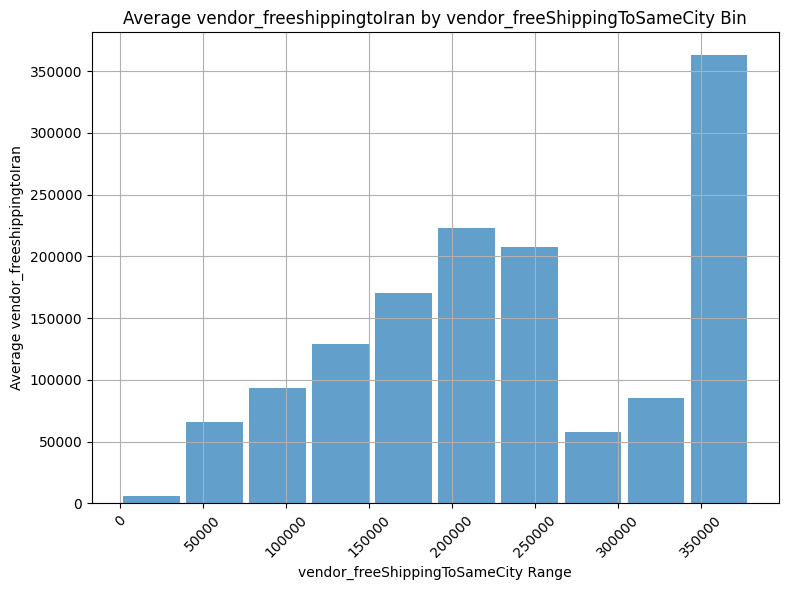

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import functions as F

# Define the number of bins you want
num_bins = 10

# Calculate bins for each vendor_freeShippingToSameCity column
vendor_freeShippingToSameCity_bins = df.select(F.min("vendor_freeShippingToSameCity"), F.max("vendor_freeShippingToSameCity")).collect()
min_vendor_freeShippingToSameCity, max_vendor_freeShippingToSameCity = vendor_freeShippingToSameCity_bins[0][0], vendor_freeShippingToSameCity_bins[0][1]
vendor_freeShippingToSameCity_bin_width = (max_vendor_freeShippingToSameCity - min_vendor_freeShippingToSameCity) / num_bins

# Create binned columns
df = df.withColumn("vendor_freeShippingToSameCity_bin", F.floor((F.col("vendor_freeShippingToSameCity") - min_vendor_freeShippingToSameCity) / vendor_freeShippingToSameCity_bin_width))
# Aggregate average vendor_freeshippingtoIran by vendor_freeShippingToSameCity bin
vendor_freeShippingToSameCity_vendor_freeshippingtoIran = df.groupBy("vendor_freeShippingToSameCity_bin").agg(
    F.avg("vendor_freeshippingtoIran").alias("avg_vendor_freeshippingtoIran"),
    F.count("*").alias("count")
).orderBy("vendor_freeShippingToSameCity_bin")
# Convert aggregated data to Pandas DataFrames
vendor_freeShippingToSameCity_pd = vendor_freeShippingToSameCity_vendor_freeshippingtoIran.toPandas()
# Calculate bin centers
vendor_freeShippingToSameCity_pd['bin_center'] = min_vendor_freeShippingToSameCity + (vendor_freeShippingToSameCity_pd['vendor_freeShippingToSameCity_bin'] + 0.5) * vendor_freeShippingToSameCity_bin_width


# Assuming df is your PySpark DataFrame
# First convert the necessary columns to Pandas
pdf = df.select("vendor_freeShippingToSameCity", "vendor_freeshippingtoIran").toPandas()

# Set up the figure
plt.figure(figsize=(15, 6))

# 1. vendor_freeShippingToSameCity vs vendor_freeshippingtoIran histogram
plt.subplot(1, 2, 1)

# Create bins for vendor_freeShippingToSameCity
vendor_freeShippingToSameCity_bins = np.linspace(pdf['vendor_freeShippingToSameCity'].min(), pdf['vendor_freeShippingToSameCity'].max(), num_bins + 1)
pdf['vendor_freeShippingToSameCity_bin'] = pd.cut(pdf['vendor_freeShippingToSameCity'], bins=vendor_freeShippingToSameCity_bins)

# Calculate average vendor_freeshippingtoIran per bin
vendor_freeShippingToSameCity_stats = pdf.groupby('vendor_freeShippingToSameCity_bin')['vendor_freeshippingtoIran'].agg(['mean', 'count']).reset_index()

# Plot
plt.bar(vendor_freeShippingToSameCity_stats['vendor_freeShippingToSameCity_bin'].apply(lambda x: x.mid), 
        vendor_freeShippingToSameCity_stats['mean'], 
        width=(vendor_freeShippingToSameCity_bins[1]-vendor_freeShippingToSameCity_bins[0])*0.9,  # 90% of bin width for spacing
        alpha=0.7)
plt.title('Average vendor_freeshippingtoIran by vendor_freeShippingToSameCity Bin')
plt.xlabel('vendor_freeShippingToSameCity Range')
plt.ylabel('Average vendor_freeshippingtoIran')
plt.xticks(rotation=45)
plt.grid(True)

# 2. vendor_freeShippingToSameCity vs vendor_freeshippingtoIran histogram
plt.subplot(1, 2, 1)

plt.tight_layout()
plt.show()

_score vs name

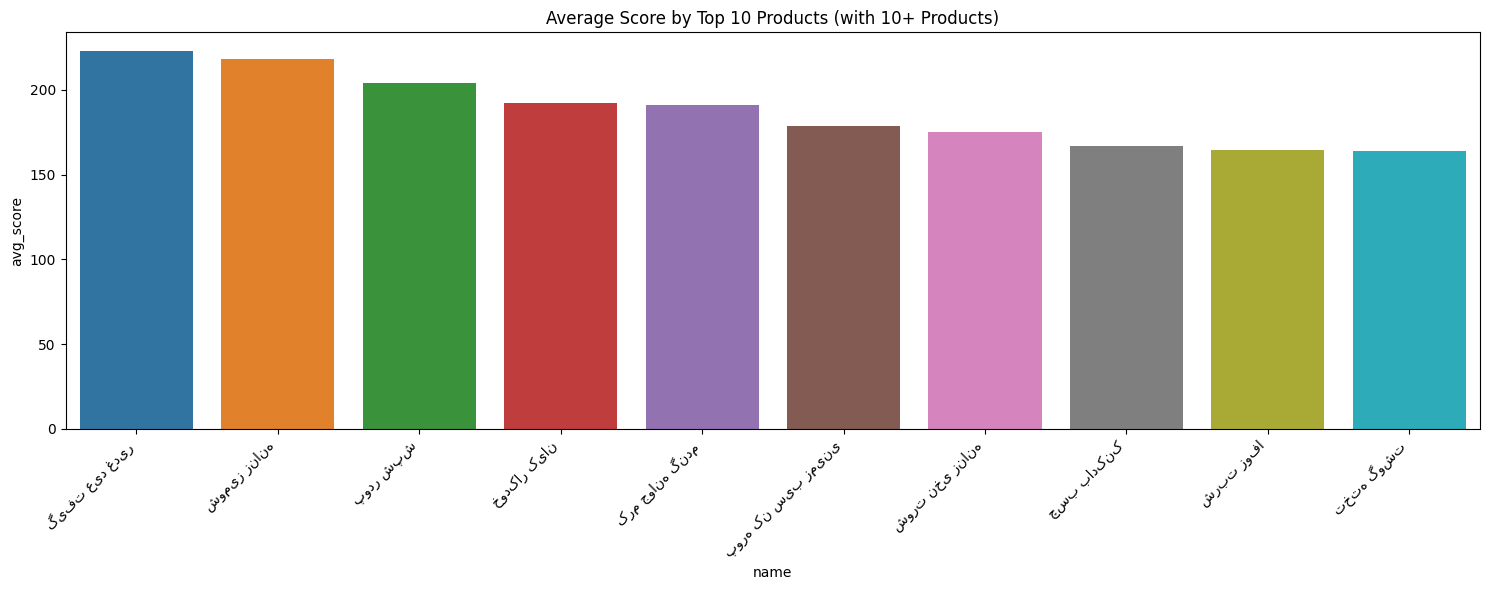

Product Statistics:


,name,avg_score,product_count
1172248,گیفت عید غدیر,222.747501,11
653214,شومیز زنانه,218.148349,11
1717505,پودر شپش,204.045916,11
24409,خودکار کیان,191.923527,10
1165690,کرم جوانه گندم,191.106184,18
269652,پوره کن سیب زمینی,178.485597,14
1810466,شورت نخی زنانه,175.312386,12
1349623,چسب بادکنک,166.790737,14
28730,شربت زوفا,164.477507,11
1729442,تخته گوشت,164.177491,11


In [30]:
product_analysis = df.groupBy('name').agg(
    F.avg('_score').alias('avg_score'),
    F.count('*').alias('product_count'),
).toPandas()

product_analysis = product_analysis[product_analysis['product_count'] >= 10]

plt.figure(figsize=(15, 6))
top_products = product_analysis.nlargest(10, 'avg_score')
sns.barplot(data=top_products, x='name', y='avg_score')
plt.xticks(rotation=45, ha='right')
plt.title('Average Score by Top 10 Products (with 10+ Products)')
plt.tight_layout()
plt.show()

print("Product Statistics:")
display(product_analysis.sort_values('avg_score', ascending=False).head(10))


has_delivery vs vendor_has_delivery

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


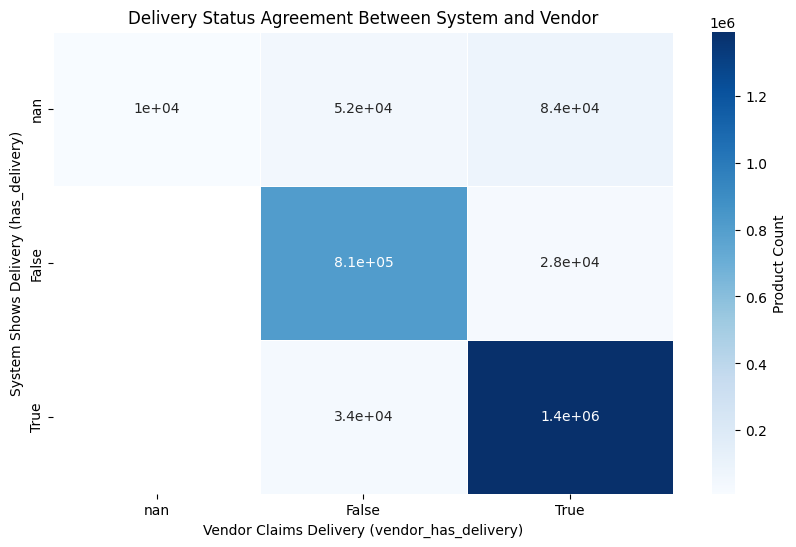

In [31]:
from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Create contingency table
delivery_analysis = df.groupBy("has_delivery", "vendor_has_delivery").agg(
    F.count("*").alias("count"),
).orderBy("has_delivery", "vendor_has_delivery")

# Prepare data for heatmap
delivery_pd = delivery_analysis.toPandas()
heatmap_data = delivery_pd.pivot(
    index="has_delivery",
    columns="vendor_has_delivery",
    values="count"
)

plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap="Blues",
    linewidths=.5,
    cbar_kws={'label': 'Product Count'}
)
plt.title("Delivery Status Agreement Between System and Vendor")
plt.xlabel("Vendor Claims Delivery (vendor_has_delivery)")
plt.ylabel("System Shows Delivery (has_delivery)")
plt.show()

IsFreeShipping vs price


In [32]:
from pyspark.sql import functions as F

# Calculate average price by free shipping status
free_shipping_stats = df.groupBy("isFreeShipping").agg(
    F.avg("price").alias("average_price"),
    F.count("*").alias("product_count"),
    F.stddev("price").alias("price_stddev")
).orderBy("isFreeShipping")

# Show the results
free_shipping_stats.show()

+--------------+------------------+-------------+------------------+
|isFreeShipping|     average_price|product_count|      price_stddev|
+--------------+------------------+-------------+------------------+
|         false|2719.0726984141443|      1962935|11512.206713118288|
|          true| 7034.415226796704|       447545|17981.626783850912|
+--------------+------------------+-------------+------------------+



In [33]:
from pyspark.sql import functions as F

# Create flags for media presence
df = df.withColumn("has_photo", F.col("photo_MEDIUM").isNotNull() | F.col("photo_SMALL").isNotNull())
df = df.withColumn("has_video", F.col("video_ORIGINAL").isNotNull())

# Group by product name and calculate average scores
result = df.groupBy("name").agg(
    F.first("has_photo").alias("has_photo"),
    F.first("has_video").alias("has_video"),
    F.avg("_score").alias("avg_score")
)

# Calculate overall averages for each media type
media_impact = result.groupBy("has_photo", "has_video").agg(
    F.avg("avg_score").alias("average_product_score"),
    F.count("name").alias("product_count")
).orderBy("has_photo", "has_video")

media_impact.show()

+---------+---------+---------------------+-------------+
|has_photo|has_video|average_product_score|product_count|
+---------+---------+---------------------+-------------+
|    false|    false|   18.222862316793893|          524|
|    false|     true|   13.888889333333333|            6|
|     true|    false|     68.5869924810835|      2134613|
|     true|     true|    89.28224372144084|       150089|
+---------+---------+---------------------+-------------+



## 7. Correlation Analysis

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


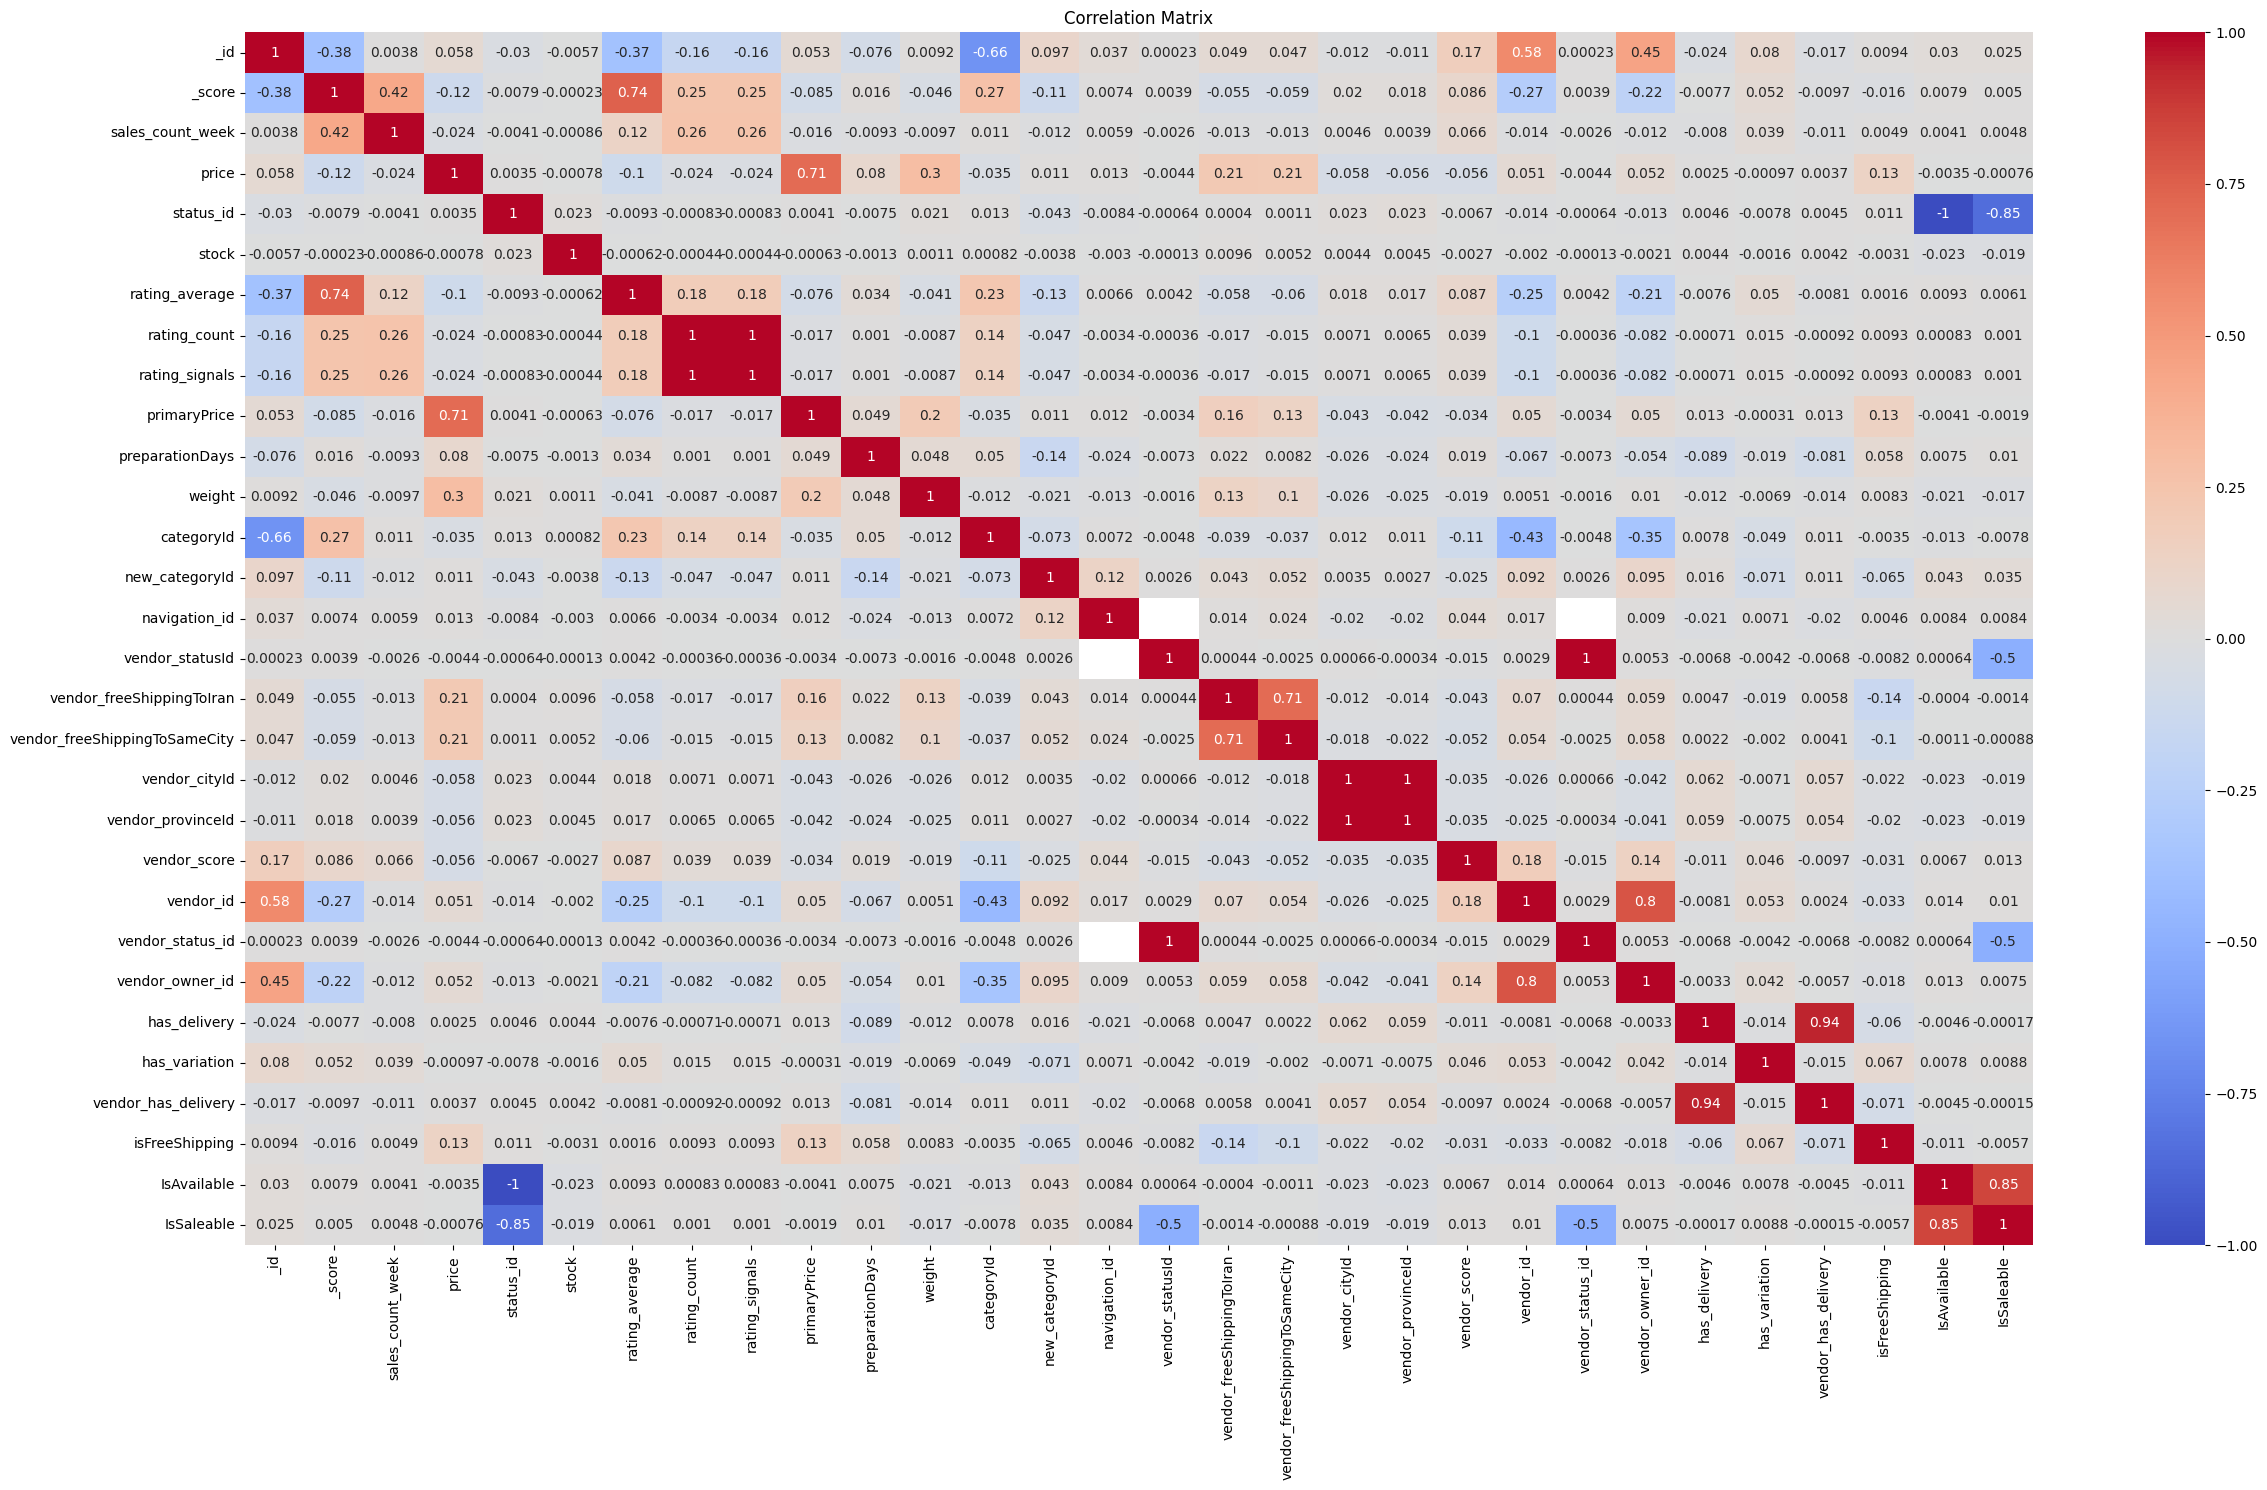

In [34]:

# Calculate and plot correlation matrix

def plot_correlation_matrix(df, columns):
    """
    Plot correlation matrix for specified columns.
    
    Args:
        df: Spark DataFrame
        columns: List of column names to include in correlation matrix
    """
    correlation_data = df.select(columns).toPandas()
    correlation_matrix = correlation_data.corr()
    
    plt.figure(figsize=(25, 15))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()
    
# Define binary columns
binary_columns = ['has_delivery', 'has_variation', 'vendor_has_delivery', 'isFreeShipping', 'IsAvailable', 'IsSaleable']

# Combine numerical and binary features
all_features = numerical_columns + binary_columns

# Plot correlation matrix with all features
plot_correlation_matrix(df, all_features)